# Оценка качества вин

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

import numpy as np
import pandas as pd
import statsmodels.stats.api as sm

%pylab inline

Populating the interactive namespace from numpy and matplotlib


P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis. **Modeling wine preferences by data mining from physicochemical properties.** *Decision Support Systems*, 47(4):547-553, 2009: имеются оценки качества 6497 португальских вин Vinho Verde, выставленные дегустаторами при слепом тестировании в баллах по шкале от 0 до 10. 

Прочитаем данные:

In [90]:
wine = pd.read_csv('wine_data.csv', sep='\t', header=0)
wine = wine.sample(frac=1)

Вот так выглядит распределение экспертных оценок вин в выборке:

Text(0.5, 0, 'Quality')

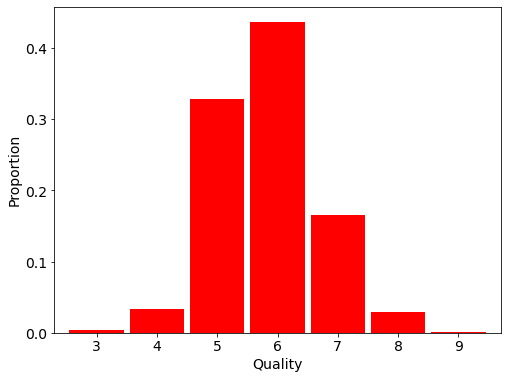

In [96]:
plt.figure(figsize(8,6))
stat = wine.groupby('quality')['quality'].agg(lambda x : float(len(x))/wine.shape[0])
stat.plot(kind='bar', fontsize=14, width=0.9, color="red")
plt.xticks(rotation=0)
plt.ylabel('Proportion', fontsize=14)
plt.xlabel('Quality', fontsize=14)

Давайте научимся оценивать этот признак, чтобы мы могли заранее предположить, какую оценку получит какое-то новое вино, которого в выборке нет. 
Чтобы смоделировать такую ситуацию, отделим 25% выборки для контроля качества предсказания:

In [23]:
X_train, X_test, y_train, y_test = train_test_split(wine.iloc[:, wine.columns != 'quality'], wine['quality'], test_size=0.25, 
                                                    stratify=wine[['Type', 'quality']])

In [24]:
X_train['Type'] = X_train['Type'].apply(lambda x : -1 if x == 'red' else 1)
X_test['Type'] = X_test['Type'].apply(lambda x : -1 if x == 'red' else 1)

Если у нас нет больше никакой информации о винах, то наше лучшее предположение об оценке — среднее имеющихся в обучающей выборке:

In [25]:
np.mean(y_train)

5.817733990147783

Если мы будем предсказывать этой величиной оценку всех вин, на обучающей выборке мы получим среднеквадратичную ошибку

In [26]:
sqrt(mean_squared_error([np.mean(y_train)]*len(y_train), y_train))

0.8735940831862377

а на тестовой

In [27]:
sqrt(mean_squared_error([np.mean(y_train)]*len(y_test), y_test))

0.8719705746838052

На тестовой выборке ошибка больше, поскольку среднее мы оценивали по обучающей. Это естественный эффект.

# Тип вина

Какая-то ещё информация у нас есть, например, о типе вина:

In [28]:
wine.groupby('Type')['Type'].count()

Type
red      1599
white    4898
Name: Type, dtype: int64

Распределения оценок по типам довольно сильно отличаются:

Text(0.5, 0, 'Quality')

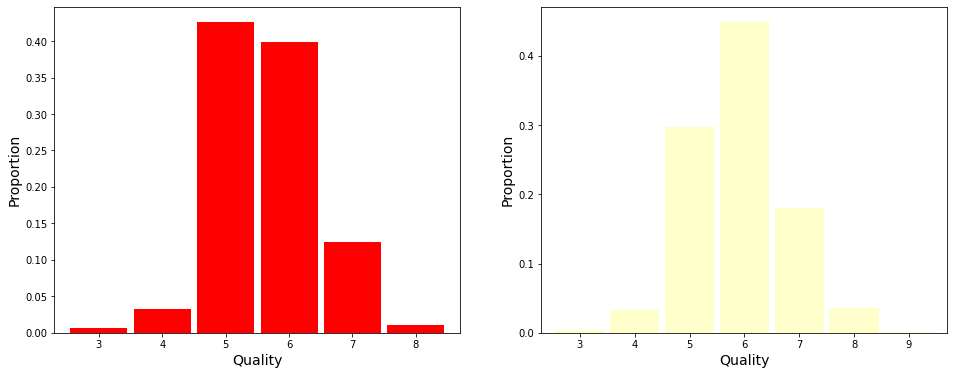

In [82]:
plt.figure(figsize(16,6))
plt.subplot(121)
stat_red = wine[wine['Type'] == 'red'].groupby('quality')['quality'].agg(lambda x: float(len(x))/wine[wine['Type'] == 'red'].shape[0])
stat_red.plot(kind='bar', color='r', width=0.9)
plt.xticks(rotation=0)
plt.ylabel('Proportion', fontsize=14)
plt.xlabel('Quality', fontsize=14)

plt.subplot(122)
stat_white = wine[wine['Type'] == 'white'].groupby('quality')['quality'].agg(lambda x: float(len(x))/wine[wine['Type'] == 'white'].shape[0])
stat_white.plot(kind='bar', color='#FFFFCC', width=0.9)
plt.xticks(rotation=0)
plt.ylabel('Proportion', fontsize=14)
plt.xlabel('Quality', fontsize=14)

Различие между средними статистически значимо:

In [83]:
tmeans = sm.CompareMeans(sm.DescrStatsW(wine[wine['Type'] == 'white']['quality']), 
                         sm.DescrStatsW(wine[wine['Type'] == 'red']['quality']))

tmeans.ttest_ind(alternative='two-sided', usevar='pooled', value=0)[1]

4.888069044202176e-22

95% доверительный интервал для разности средних оценок:

In [84]:
tmeans.tconfint_diff(alpha=0.05, alternative='two-sided', usevar='pooled')

(0.19293009404017958, 0.29084357932805205)

Чтобы уточнить наше предсказание, можно оценку каждого вина предсказывать средним по оценкам вин такого же типа в выборке:

In [85]:
regressor = LinearRegression()
regressor.fit(X_train['Type'].values.reshape(-1,1), y_train)

LinearRegression()

In [86]:
y_train_predictions = regressor.predict(X_train['Type'].values.reshape(-1,1))

In [87]:
y_test_predictions = regressor.predict(X_test['Type'].values.reshape(-1,1))

Ошибки предсказания немного уменьшились:

In [88]:
sqrt(mean_squared_error(y_train_predictions, y_train))

0.8671965001753594

In [89]:
sqrt(mean_squared_error(y_test_predictions, y_test))

0.8662137838266156

Вот так выглядят истинные оценки вин и их предсказания средними по типам на тестовой выборке:

In [40]:
pyplot.figure(figsize(8,8))
pyplot.scatter(y_test, y_test_predictions, color="red", alpha=0.1)
pyplot.xlim(2.5,9.5)
pyplot.ylim(2.5,9.5)
plot(range(11), color='black')
grid()
plt.xlabel('Quality', fontsize=14)
plt.ylabel('Estimated quality', fontsize=14)

Text(0, 0.5, 'Estimated quality')

# Другие признаки

На самом деле у нас есть ещё 11 признаков, описывающих химический состав вин:

In [41]:
wine.head()

Type  Fixed acidity (g/l)  Volatile acidity (g/l)  Citric acid (g/l)  \
4676  white                  6.2                    0.25               0.38   
4323  white                  7.5                    0.18               0.31   
2320  white                  6.0                    0.30               0.44   
4083  white                  6.4                    0.30               0.16   
5393  white                  5.5                    0.24               0.45   

      Residual sugar (g/l)  Chlorides (g/l)  Free sulfur dioxide  (mg/l)  \
4676                   7.9            0.045                         54.0   
4323                   6.5            0.029                         53.0   
2320                   1.5            0.046                         15.0   
4083                   7.5            0.050                         55.0   
5393                   1.7            0.046                         22.0   

      Total sulfur dioxide (mg/l)  Density (g/cm3)    pH  Sulphates (g/l)  \
4676                        208.0          0.99572  3.17             0.46   
4323                        160.0          0.99276  3.03             0.38   
2320                        182.0          0.99455  3.50             0.52   
4083                        191.0          0.99590  3.17             0.49   
5393                        113.0          0.99224  3.22             0.48   

      Alcohol (%)  quality  
4676          9.1        5  
4323         10.9        6  
2320         10.4        5  
4083          9.0        5  
5393         10.0        5

In [43]:
def jitter(arr):
    return arr + np.random.uniform(low=-0.35, high=0.35, size=len(arr))

pyplot.figure(figsize(16, 36))
for i in range (1, 12):
    pyplot.subplot(6, 2, i)
    pyplot.scatter(jitter(wine['quality']), wine.iloc[:, i], color=wine["Type"], edgecolors="black")
    pyplot.xlabel('Quality', fontsize=14)
    pyplot.ylabel(str(wine.columns[i]), fontsize=14)

Попробуем их учесть при построении прогноза оценок.

## Линейная регрессия

Построим для начала линейную регрессионную модель.

In [44]:
lm = LinearRegression()
lm.fit(X_train, y_train)

LinearRegression()

Ошибки предсказания существенно уменьшились:

In [45]:
sqrt(mean_squared_error(lm.predict(X_train), y_train))

0.7337255220644806

In [46]:
sqrt(mean_squared_error(lm.predict(X_test), y_test))

0.7287082708040856

Истинные оценки вин и их предсказания линейной моделью:

In [47]:
plt.figure(figsize(16,7))
plt.subplot(121)
pyplot.scatter(y_train, lm.predict(X_train), color="red", alpha=0.1)
pyplot.xlim(2.5,9.5)
pyplot.ylim(2.5,9.5)
plot(range(11), color='black')
grid()
pyplot.title('Train set', fontsize=20)
pyplot.xlabel('Quality', fontsize=14)
pyplot.ylabel('Estimated quality', fontsize=14)

plt.subplot(122)
pyplot.scatter(y_test, lm.predict(X_test), color="red", alpha=0.1)
pyplot.xlim(2.5,9.5)
pyplot.ylim(2.5,9.5)
plot(range(11), color='black')
grid()
pyplot.title('Test set', fontsize=20)
pyplot.xlabel('Quality', fontsize=14)
pyplot.ylabel('Estimated quality', fontsize=14)

Text(0, 0.5, 'Estimated quality')

Посчитаем коэффициент детерминации — долю объяснённой моделью дисперсии отклика:

In [48]:
lm.score(X_test, y_test)

0.301594707253831

## Случайный лес

Построим на обучающей выборке случайный лес:

In [49]:
rf = RandomForestRegressor(n_estimators=100, min_samples_leaf=3)

In [50]:
rf.fit(X_train, y_train)

RandomForestRegressor(min_samples_leaf=3)

Качество выросло ещё сильнее, хотя модель и переобучилась:

In [51]:
sqrt(mean_squared_error(rf.predict(X_train), y_train))

0.34912529349733196

In [52]:
sqrt(mean_squared_error(rf.predict(X_test), y_test))

0.6148444516287025

Истинные оценки вин и их предсказания случайным лесом:

Text(0, 0.5, 'Estimated quality')

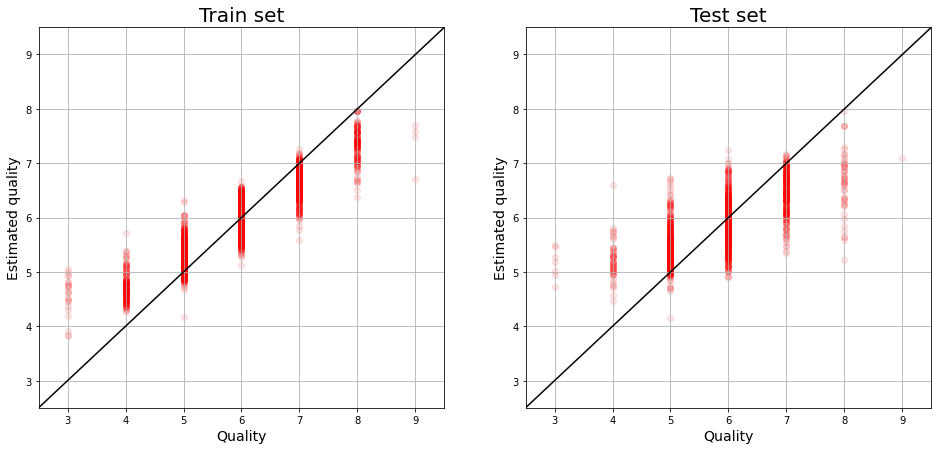

In [53]:
plt.figure(figsize(16,7))
plt.subplot(121)
pyplot.scatter(y_train, rf.predict(X_train), color="red", alpha=0.1)
pyplot.xlim(2.5,9.5)
pyplot.ylim(2.5,9.5)
plot(range(11), color='black')
grid()
pyplot.title('Train set', fontsize=20)
pyplot.xlabel('Quality', fontsize=14)
pyplot.ylabel('Estimated quality', fontsize=14)

plt.subplot(122)
pyplot.scatter(y_test, rf.predict(X_test), color="red", alpha=0.1)
pyplot.xlim(2.5,9.5)
pyplot.ylim(2.5,9.5)
plot(range(11), color='black')
grid()
pyplot.title('Test set', fontsize=20)
pyplot.xlabel('Quality', fontsize=14)
pyplot.ylabel('Estimated quality', fontsize=14)

Коэффициент детерминации для случайного леса:

In [54]:
rf.score(X_test, y_test)

0.5028005483456912

Сравним ошибки линейной регрессии и случайного леса на тестовой выборке:

In [56]:
plt.figure(figsize(8,6))
plt.hist(abs(y_test - lm.predict(X_test)) - abs(y_test - rf.predict(X_test)), bins=15, density=True, stacked=True)
plt.xlabel('Difference of absolute errors')

Text(0.5, 0, 'Difference of absolute errors')

Различия между средними абсолютными ошибками значимы:

In [57]:
tmeans = sm.CompareMeans(sm.DescrStatsW(abs(y_test - lm.predict(X_test))), 
                         sm.DescrStatsW(abs(y_test - rf.predict(X_test))))

tmeans.ttest_ind(alternative='two-sided', usevar='pooled', value=0)[1]

7.058283683210369e-14

95% доверительный интервал для средней разности абсолютных ошибок:

In [58]:
tmeans.tconfint_diff(alpha=0.05, alternative='two-sided', usevar='pooled')

(0.08418148334240164, 0.14356324039443788)

То есть, используя вместо линейной регрессии наш случайный лес, мы предсказываем экспертную оценку в среднем на 0.26-0.30 баллов точнее.

Давайте посмотрим, какие признаки обладают наибольшей предсказательной способностью:

In [59]:
importances = pd.DataFrame(zip(X_train.columns, rf.feature_importances_))
importances.columns = ['feature name', 'importance']
importances.sort_values(by='importance', ascending=False)

feature name  importance
11                  Alcohol (%)    0.278223
2        Volatile acidity (g/l)    0.135235
6   Free sulfur dioxide  (mg/l)    0.087815
10              Sulphates (g/l)    0.078625
7   Total sulfur dioxide (mg/l)    0.069601
4          Residual sugar (g/l)    0.067511
9                            pH    0.062110
5               Chlorides (g/l)    0.060190
3             Citric acid (g/l)    0.055518
8               Density (g/cm3)    0.054107
1           Fixed acidity (g/l)    0.050451
0                          Type    0.000613

Cильнее всего на экспертную оценку качества вина влияет содержание алкоголя.